<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/GuidedGradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

In [4]:
import platform
print(platform.system())

Linux


In [5]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1) DATA PRE-PROCESSING

a) Load in labels + image file paths

b) combine them into one dataframe

c) EDA - spotted and removed erroneous label (speed = 1.42...)

- `cleaned_df` is the cleaned df with a) b) c) completed

d) convert images to numerical RGB feature maps - ML algorithms only understand numerical data

e) Splitting data into training and validation sets

f) data augmentation applied to training set

### 1a) load in labels + image file paths

In [7]:
labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
#labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
# labels_file_path = '/home/ppytr13/machine-learning-in-science-ii-2025/training_norm.csv' # tyler hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [8]:
#image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data' # ben hpc file path (mlis2 cluster)
# image_folder_path = '/home/ppytr13/machine-learning-in-science-ii-2025//training_data/training_data'
image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [9]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [10]:
imagefilepaths_df.head()

,image_file_paths
image_id,
8,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/8.png
9,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/9.png
14,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/14.png
15,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/15.png
16,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/16.png


### 1b) Combine labels and image file paths into one dataframe

In [11]:
merged_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
merged_df['speed'] = merged_df['speed'].round(6) # to get rid of floating point errors

In [12]:
merged_df.head()

,angle,speed,image_file_paths
image_id,,,
8,0.500,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/8.png
9,0.500,0.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/9.png
14,0.875,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/14.png
15,0.625,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/15.png
16,0.500,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/16.png


In [13]:
merged_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3140,0.875,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3143.png


The above cell shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

### 1c) EDA

In [14]:
merged_df.value_counts('speed')

,count
speed,
1.0,3912
0.0,1323


note: imbalance datset

identifying the row with the erroneous speed value

In [15]:
merged_df[merged_df['speed'] == 1.428571]

,angle,speed,image_file_paths
image_id,,,


we want to remove this row

In [16]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]
cleaned_df.loc[3882:3886]

,angle,speed,image_file_paths
image_id,,,


### 1d) convert images to numerical RGB feature maps

In [17]:
def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalise pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["speed"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

lets check and see if what we have done works

In [18]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

(32, 224, 224, 3) (32,)


### 1e) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [19]:
# 80-20 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [20]:
print(f"Train size: {train_size}, validation size: {dataset_size - train_size}")

Train size: 131, validation size: 33


### 1f) Data Augmentation applied to training set

- Random Horizontal Flip
- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment
- Random Vertical Flip



In [21]:
def augment_image(image, label):
  seed = (6, 9)
  image = tf.image.stateless_random_brightness(image, 0.2, seed)
  image = tf.image.stateless_random_contrast(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_hue(image, 0.2, seed)
  image = tf.image.stateless_random_saturation(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_flip_left_right(image, seed)
  image = tf.image.stateless_random_flip_up_down(image, seed)
  return image, label

# Create a dataset of augmented images from the original train_dataset
augmented_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Concatenate the original and augmented datasets
train_dataset = train_dataset.concatenate(augmented_dataset)

# Shuffle the combined dataset
train_dataset = train_dataset.shuffle(buffer_size=len(cleaned_df))

count how many images are in the training set

In [31]:
total_images = 0
for image_batch, _ in train_dataset:
    total_images += image_batch.shape[0]  # Add the batch size

print(f"Total number of images in train_dataset: {total_images}")

Total number of images in train_dataset: 8384


checking to see if whats been done was successful or needs debugging

image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1


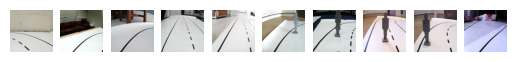

In [32]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()

# 2) Model Building - MobileNetV3Large Transfer Learning

a) Set up model architecture

b) define training step

c) training the model on the training set

d) fine-tuning

### 2a) Set up model architecture

- MobileNetV2 to learn lower level features
- global average pooling layer
- drop out layer
- dense layer with sigmoid activation

In [26]:
dropoutrate = 0.2
num_classes = 1 # we're only predicting the prob of the positive class with a sigmoid
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             961 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,997,313 (11.43 MB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

### 2b) Define training step

- adam optimiser
- binary cross entropy loss function

In [27]:
LR = 0.001  # learning rate
optimizer = tf.optimizers.Adam(LR)

@tf.function
def train_step(model, X, Y):
    with tf.GradientTape() as tape:
        pred = model(X)  # Get the predictions from the model

        # Use binary cross-entropy for binary classification
        current_loss = tf.reduce_mean(tf.losses.binary_crossentropy(Y, pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Threshold predictions to binary values (0 or 1) for accuracy calculation
    pred_binary = tf.cast(pred > 0.5, dtype=tf.int32)  # Convert predictions to binary (0 or 1)

    # Calculate True Positives, False Positives, True Negatives, False Negatives
    TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y == 1), dtype=tf.int32))
    TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y == 0), dtype=tf.int32))
    FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y == 0), dtype=tf.int32))
    FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y == 1), dtype=tf.int32))

    # Calculate Balanced Accuracy
    sensitivity = TP / (TP + FN)  # Recall for class 1
    specificity = TN / (TN + FP)  # Recall for class 0
    balanced_accuracy = 0.5 * (sensitivity + specificity)

    return current_loss, balanced_accuracy


### 2c) Training the model on the training set

In [28]:
niter = 50

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_accs = []
    for image_batch, label_batch in train_dataset:
        # Convert labels to correct format for binary classification
        # Convert to [batch_size, 1] for binary classification with sigmoid
        labels = tf.expand_dims(tf.cast(label_batch, dtype=tf.float32), axis=1)
        loss, acc = train_step(model, image_batch, labels)
        batch_losses.append(loss)
        batch_accs.append(acc)

    # Average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses).numpy()
    avg_acc = tf.reduce_mean(batch_accs).numpy()
    tloss.append(avg_loss)
    tacc.append(avg_acc)

    # LOGGING METRICS TO CHECK HOW TRAIING IS GOING

    if it % 10 == 0:
        tf.print(f'iter: {it}, train_loss: {avg_loss:.3f}, train_balanced_acc: {avg_acc:.3f}')

        # If you have a validation dataset, evaluate on it
        if 'val_dataset' in globals():
            val_losses = []
            val_accs = []
            for val_images, val_labels in val_dataset:
                val_labels = tf.expand_dims(tf.cast(val_labels, dtype=tf.float32), axis=1)
                val_preds = model(val_images)
                val_loss = tf.reduce_mean(tf.losses.binary_crossentropy(val_labels, val_preds))

                # Use the same balanced accuracy calculation as in train_step
                pred_binary = tf.cast(val_preds > 0.5, dtype=tf.int32)
                val_labels_int = tf.cast(val_labels, dtype=tf.int32)

                TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 1), dtype=tf.int32))
                TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 0), dtype=tf.int32))
                FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 0), dtype=tf.int32))
                FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 1), dtype=tf.int32))

                sensitivity = TP / (TP + FN + 1e-7)
                specificity = TN / (TN + FP + 1e-7)
                val_acc = 0.5 * (sensitivity + specificity)

                val_losses.append(val_loss)
                val_accs.append(val_acc)

            avg_val_loss = tf.reduce_mean(val_losses).numpy()
            avg_val_acc = tf.reduce_mean(val_accs).numpy()
            vloss.append(avg_val_loss)
            vacc.append(avg_val_acc)

            tf.print(f'val_loss: {avg_val_loss:.3f}, val_balanced_acc: {avg_val_acc:.3f}')

KeyboardInterrupt: 

In [ ]:
model.save_weights('/home/apyba3/car_frozen_regression_mobv3.weights.h5')
# model.save_weights('/home/ppytr13/car_frozen.weights.h5')

In [ ]:
tf.keras.backend.clear_session() #Clear keras session

### 2d) fine-tuning

rebuild model after clearing keras session

In [ ]:
dropoutrate = 0.2
num_classes = 1 # we're only predicting the prob of the positive class with a sigmoid
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
model.build()

mbnet.trainable = True # UNFREEZE the first layers to the imagenet weights

model.summary() # print the model

In [ ]:
model.load_weights('/home/apyba3/car_frozen_regression_mobv3.weights.h5')
# model.load_weights('/home/ppytr13/car_frozen.weights.h5')

Set up fine-tuning training

In [ ]:
LR = 0.0001
optimizer = tf.optimizers.Adam(LR) #adam optimiser

In [ ]:
@tf.function
def train_step(model, X, Y):
    with tf.GradientTape() as tape:
        pred = model(X)  # Get the predictions from the model

        # Use binary cross-entropy for binary classification
        current_loss = tf.reduce_mean(tf.losses.binary_crossentropy(Y, pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Threshold predictions to binary values (0 or 1) for accuracy calculation
    pred_binary = tf.cast(pred > 0.5, dtype=tf.int32)  # Convert predictions to binary (0 or 1)

    # Calculate True Positives, False Positives, True Negatives, False Negatives
    TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y == 1), dtype=tf.int32))
    TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y == 0), dtype=tf.int32))
    FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y == 0), dtype=tf.int32))
    FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y == 1), dtype=tf.int32))

    # Calculate Balanced Accuracy
    sensitivity = TP / (TP + FN)  # Recall for class 1
    specificity = TN / (TN + FP)  # Recall for class 0
    balanced_accuracy = 0.5 * (sensitivity + specificity)

    return current_loss, balanced_accuracy

In [ ]:
niter = 50

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_accs = []
    for image_batch, label_batch in train_dataset:
        # Convert labels to correct format for binary classification
        # Convert to [batch_size, 1] for binary classification with sigmoid
        labels = tf.expand_dims(tf.cast(label_batch, dtype=tf.float32), axis=1)
        loss, acc = train_step(model, image_batch, labels)
        batch_losses.append(loss)
        batch_accs.append(acc)

    # Average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses).numpy()
    avg_acc = tf.reduce_mean(batch_accs).numpy()
    tloss.append(avg_loss)
    tacc.append(avg_acc)

    # LOGGING METRICS TO CHECK HOW TRAIING IS GOING

    if it % 10 == 0:
        tf.print(f'iter: {it}, train_loss: {avg_loss:.3f}, train_balanced_acc: {avg_acc:.3f}')

        # If you have a validation dataset, evaluate on it
        if 'val_dataset' in globals():
            val_losses = []
            val_accs = []
            for val_images, val_labels in val_dataset:
                val_labels = tf.expand_dims(tf.cast(val_labels, dtype=tf.float32), axis=1)
                val_preds = model(val_images)
                val_loss = tf.reduce_mean(tf.losses.binary_crossentropy(val_labels, val_preds))

                # Use the same balanced accuracy calculation as in train_step
                pred_binary = tf.cast(val_preds > 0.5, dtype=tf.int32)
                val_labels_int = tf.cast(val_labels, dtype=tf.int32)

                TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 1), dtype=tf.int32))
                TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 0), dtype=tf.int32))
                FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 0), dtype=tf.int32))
                FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 1), dtype=tf.int32))

                sensitivity = TP / (TP + FN + 1e-7)
                specificity = TN / (TN + FP + 1e-7)
                val_acc = 0.5 * (sensitivity + specificity)

                val_losses.append(val_loss)
                val_accs.append(val_acc)

            avg_val_loss = tf.reduce_mean(val_losses).numpy()
            avg_val_acc = tf.reduce_mean(val_accs).numpy()
            vloss.append(avg_val_loss)
            vacc.append(avg_val_acc)

            tf.print(f'val_loss: {avg_val_loss:.3f}, val_balanced_acc: {avg_val_acc:.3f}')

In [ ]:
model.save_weights('car_unfrozen_regression_mobv3.weights.h5')
# model.save_weights('/home/ppytr13/car_unfrozen.weights.h5')

# 3) Test-Set Predictions

a) load in test data

b) convert test images to numerical RGB feature maps

c) generate predictions on the test set

d) correctly format the predictions into a pandas dataframe

e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

### 3a) load in test data

In [30]:
#image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/test_data/test_data' # tylers file path

image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/content/drive/MyDrive/machine-learning-in-science-ii-2025/test_data/test_data/1.png
2,/content/drive/MyDrive/machine-learning-in-science-ii-2025/test_data/test_data/2.png
3,/content/drive/MyDrive/machine-learning-in-science-ii-2025/test_data/test_data/3.png
4,/content/drive/MyDrive/machine-learning-in-science-ii-2025/test_data/test_data/4.png
5,/content/drive/MyDrive/machine-learning-in-science-ii-2025/test_data/test_data/5.png


### 3b) convert test images to numerical RGB feature maps

In [31]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 3c) generate predictions on test set

In [32]:
predictions = model.predict(test_dataset)

Exception ignored in: <function _xla_gc_callback at 0x7c784bea9760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


KeyboardInterrupt: 

### 3d) correctly format the predictions into a pandas dataframe

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['speed'])

In [ ]:
predictions_df.head()

sigmoid output is between [0,1]

In [ ]:
predictions_df[predictions_df['speed'] > 0.5] = 1
predictions_df[predictions_df['speed'] < 0.5] = 0

kaggle expects integers for the speed column

In [ ]:
predictions_df['speed'] = predictions_df['speed'].astype(int)

In [ ]:
predictions_df.head()

In [ ]:
predictions_df['speed'].value_counts()

### 3e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

In [ ]:
predictions_df.to_csv('/home/apyba3/mbnetv3_speedclassification_predictions.csv')

# 4) Working Guided GradCAM

In [1]:
pip install tensorflow matplotlib opencv-python


In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input


# Step 1: defining the guided Grad-CAM Function
Basic info on what it is:the Guided Grad-CAM combines both the Grad-CAM and Guided Backpropagation techniques. First i will compute the gradients of the predicted class with respect to the output feature map. Then i will using these gradients, then will highlight the relevant regions in the image.

In [34]:
def guided_gradcam(model, img_array, class_index=None):

    # gets the model's output layer
    last_conv_layer = model.get_layer('conv2d')  # This can vary based on your architecture
    heatmap_model = Model([model.inputs], [last_conv_layer.output, model.output])

    # calculates the gradient of the class with respect to the last convolutional layer output
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = heatmap_model(img_array)
        class_index = tf.argmax(preds[0]) if class_index is None else class_index
        class_channel = preds[:, class_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    # hre we use the guided backpropagation gradients here
    guided_grads = grads * tf.cast(last_conv_layer_output > 0, 'float32')

    # pool the gradients across all the channels
    pooled_grads = tf.reduce_mean(guided_grads, axis=(0, 1, 2))

    # Mmultiply each channel by the pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    for i in range(last_conv_layer_output.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # reate the heatmap
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)  # Normalize the heatmap

    # resize the heatmap to the size of the input image
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[2], img_array.shape[1]))

    return heatmap


# step 2: overlay Grad-CAM on the Image
Once we have the Grad-CAM heatma we can overlay it on the original image to see which parts of the image the model is focusing on.

In [35]:
def overlay_gradcam(heatmap, img_array, alpha=0.4):

    # convertingthe image to the range [0, 255]
    img_array = img_array[0]
    img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    img_array = np.uint8(255 * img_array)

    # converting the heatmap to the range [0, 255]
    heatmap = np.uint8(255 * heatmap)

    # applys a colormap to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # overlay the heatmap on the image
    gradcam_img = cv2.addWeighted(img_array, 1 - alpha, heatmap, alpha, 0)

    return gradcam_img


# step 3:Run Guided Grad-CAM on the Images
 we now loop over the images in our test/validation dataset, process them, and generate the visualisations.

In [36]:
# here I just loaded an example image from the dataset (we can loop over this for all images)
image_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3045.png'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# ppreprocess the image
img_array = preprocess_input(img_array)

# generate Grad-CAM heatmap
heatmap = guided_gradcam(model, img_array)

# ovverlay Grad-CAM heatmap on the original image
gradcam_img = overlay_gradcam(heatmap, img_array)

# display the original image and the Grad-CAM overlay
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradcam_img)
plt.title("Guided Grad-CAM")
plt.axis('off')

plt.show()


ValueError: No such layer: conv2d. Existing layers are: ['MobileNetV3Large', 'global_average_pooling2d', 'dropout', 'dense'].

# Final step: Batch Processing Ik this is probally optinal but i tried to include it.
loops through the images in the dataset, process them, and save/display the Grad-CAM results for each one.

In [ ]:
for image_path in image_file_paths:
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Generate Grad-CAM heatmap and overlay it
    heatmap = guided_gradcam(model, img_array)
    gradcam_img = overlay_gradcam(heatmap, img_array)

    # Save the image or display it
    output_path = '/content/grad_cam_outputs/{}'.format(os.path.basename(image_path))
    cv2.imwrite(output_path, gradcam_img)  # Save the image


In [46]:
base_model = model.get_layer("MobileNetV3Large")
for layer in base_model.layers:
    print(layer.name, layer.output.shape)


input_layer (None, 224, 224, 3)
rescaling (None, 224, 224, 3)
conv (None, 112, 112, 16)
conv_bn (None, 112, 112, 16)
activation (None, 112, 112, 16)
expanded_conv_depthwise (None, 112, 112, 16)
expanded_conv_depthwise_bn (None, 112, 112, 16)
re_lu (None, 112, 112, 16)
expanded_conv_project (None, 112, 112, 16)
expanded_conv_project_bn (None, 112, 112, 16)
expanded_conv_add (None, 112, 112, 16)
expanded_conv_1_expand (None, 112, 112, 64)
expanded_conv_1_expand_bn (None, 112, 112, 64)
re_lu_1 (None, 112, 112, 64)
expanded_conv_1_depthwise_pad (None, 113, 113, 64)
expanded_conv_1_depthwise (None, 56, 56, 64)
expanded_conv_1_depthwise_bn (None, 56, 56, 64)
re_lu_2 (None, 56, 56, 64)
expanded_conv_1_project (None, 56, 56, 24)
expanded_conv_1_project_bn (None, 56, 56, 24)
expanded_conv_2_expand (None, 56, 56, 72)
expanded_conv_2_expand_bn (None, 56, 56, 72)
re_lu_3 (None, 56, 56, 72)
expanded_conv_2_depthwise (None, 56, 56, 72)
expanded_conv_2_depthwise_bn (None, 56, 56, 72)
re_lu_4 (None, 5

In [49]:
last_conv_layer = base_model.get_layer("conv_1_bn").output


In [52]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models

def grad_cam(input_model, image, layer_name="conv_1_bn"):

    last_conv_layer = input_model.get_layer(layer_name).output
    classifier_input = input_model.input
    classifier_output = input_model.output
    grad_model = models.Model([classifier_input], [last_conv_layer, classifier_output])
    with tf.GradientTape() as tape:

        tape.watch(image)
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def display_grad_cam(heatmap, image, alpha=0.4):

    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = np.repeat(heatmap, 3, axis=-1)


    superimposed_img = image * (1 - alpha) + heatmap * alpha


    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Working GradCAM on one image.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1093']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


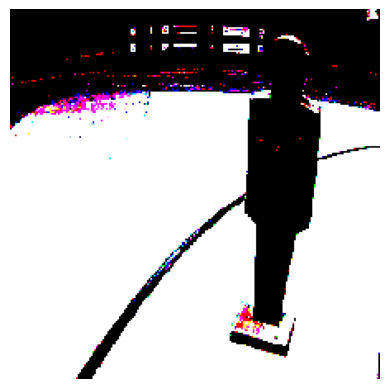

In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2  # OpenCV for resizing

# Grad-CAM function with corrected layer name
def grad_cam(input_model, image, layer_name="conv1_bn"):
    # convert the image to a tf.Tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    last_conv_layer = input_model.get_layer(layer_name).output
    classifier_input = input_model.input
    classifier_output = input_model.output

    grad_model = tf.keras.models.Model([classifier_input], [last_conv_layer, classifier_output])

    with tf.GradientTape() as tape:
        tape.watch(image)
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# ffunction to display Grad-CAM
def display_grad_cam(heatmap, image, alpha=0.4):
    # i had to resize heatmap to match the input image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = np.repeat(heatmap, 3, axis=-1)

    # resize heatmap to the original image dimensions (224x224)
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    superimposed_img = image * (1 - alpha) + heatmap_resized * alpha

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# loading pre-trained model (ResNet50 example)
base_model = tf.keras.applications.ResNet50(weights='imagenet')

# load and preprocess the image
img_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3045.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# preprocessing image
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

# add batch dimension
img_array = np.expand_dims(img_array, axis=0)

# generate and display Grad-CAM
heatmap = grad_cam(base_model, img_array)
display_grad_cam(heatmap, img_array[0])



In [51]:

last_conv_layer = base_model.get_layer("conv_1_bn").output



In [48]:
for layer in model.layers[::-1]:  # Iterate in reverse
    if 'conv' in layer.name.lower():
        print(layer.name)
        break  # Stop at the last convolutional layer


In [50]:
heatmap = guided_gradcam(model, img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


AttributeError: The layer sequential has never been called and thus has no defined input.